In [9]:
import pandas as pd
import random

def create_random_text_file(csv_file, num_values, output_file):
    df = pd.read_csv(csv_file)

    symbol_values = df['Symbol'].tolist()

    random_indices = random.sample(range(len(symbol_values)), min(num_values, len(symbol_values)))

    random_symbols = [symbol_values[i] for i in random_indices]

    with open(output_file, 'w') as file:
        #file.write("Ticker") 
        for symbol in random_symbols:
            file.write(f"{symbol}\n")

    print(f"Written to {output_file}")

create_random_text_file('RAW_stocknames.csv', 50, 'ticker.csv')

Written to ticker.csv


NNAVW: Period '1mo' is invalid, must be one of ['1d', '5d']


Valid Ticker Symbols:
MSFT
SREA
GTE
CATO
LVO
INFU
BLUE
OKE
GOEV
STLD
TG
VABK
NEOV
HHS
BGNE
GCV
KEYS
SPIR
SNDA
HRL
RDY
BANX
VFS
SRT
DB
CDZI
LICY
CM
FLL
EOG
ELTK
HBAN
FHTX
GOCO
AVGO
TRI
PATH
KOD
COR
ENTA
NAUT
WEYS
UBFO
DRTS
SLDB
UPLD
ANVS
OZK
DT

Close Week Data:
                                 MSFT       SREA   GTE      CATO   LVO  \
Date                                                                     
2021-01-10 00:00:00-05:00  213.876114  22.691219  4.40  8.349212  3.89   
2021-01-17 00:00:00-05:00  207.088440  22.977070  5.10  9.464114  3.71   
2021-01-24 00:00:00-05:00  220.040573  23.111584  5.00  9.480882  4.39   
2021-01-31 00:00:00-05:00  225.893387  22.951849  5.90  9.531178  3.81   
2021-02-07 00:00:00-05:00  235.865585  23.103176  6.50  9.262933  4.37   
...                               ...        ...   ...       ...   ...   
2023-12-03 00:00:00-05:00  374.510010  23.831871  6.43  6.959282  1.06   
2023-12-10 00:00:00-05:00  374.230011  23.620098  5.89  6.656704  1.07  

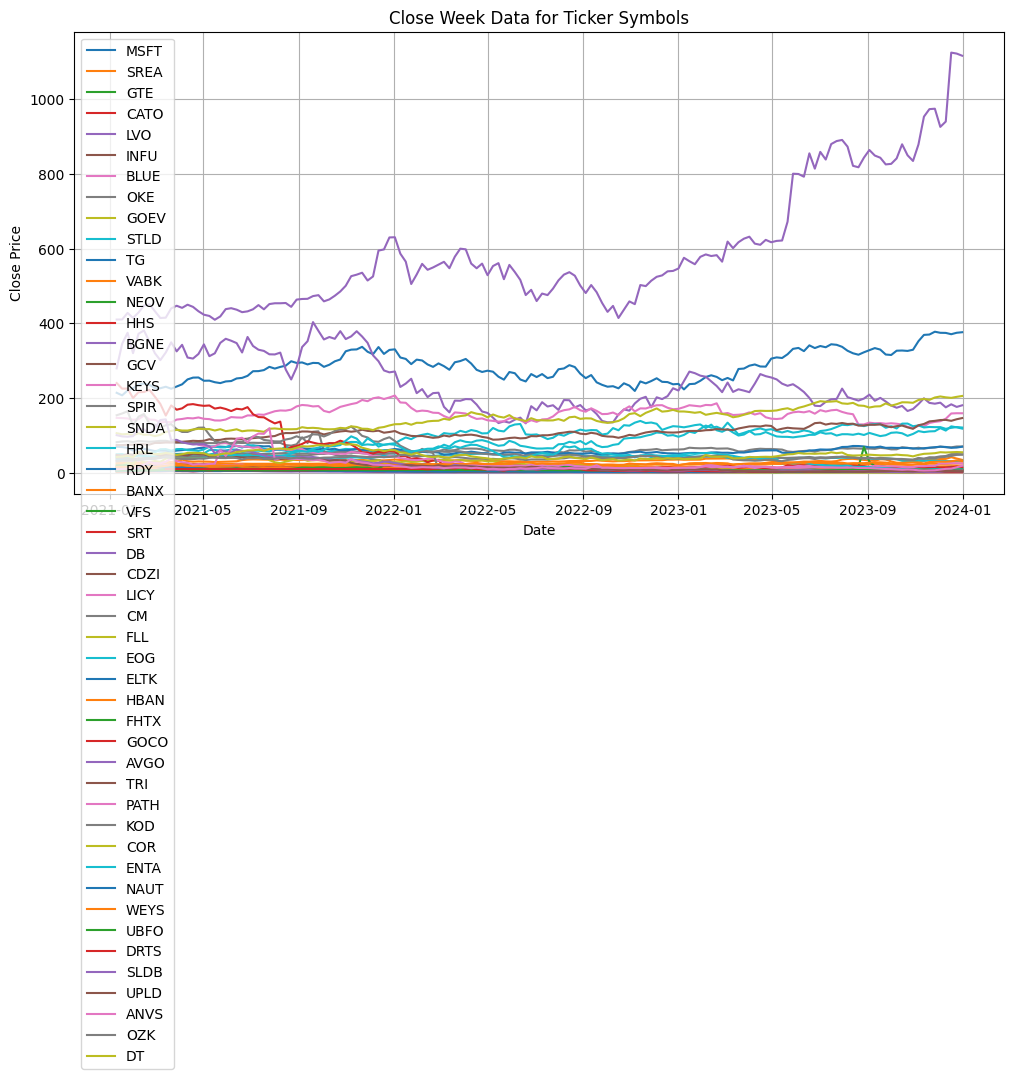

In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def get_ticker_symbols():
    ticker_symbols = pd.read_csv("ticker.csv", header=None)[0].tolist()
    return ticker_symbols

def validate_ticker_symbol(symbol):
    ticker = yf.Ticker(symbol)
    data = ticker.history()
    
    if data.empty:
        return False
    else:
        return True

def get_close_weeks(start_date, end_date):
    ticker_symbols = get_ticker_symbols()
    valid_ticker_symbols = []
    close_week_data = pd.DataFrame()
    
    for symbol in ticker_symbols:
        if validate_ticker_symbol(symbol):
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)
            
            if not data.empty:
                weekly_data = data.resample('W').last().dropna()
                
                if not weekly_data.empty:
                    valid_ticker_symbols.append(symbol)
                    close_week_data[symbol] = weekly_data['Close']
    
    return valid_ticker_symbols, close_week_data

start_date = '2021-01-01'
end_date = '2024-01-01'

valid_symbols, close_week_data = get_close_weeks(start_date, end_date)

close_week_data.to_csv("net_changes.csv")

print("Valid Ticker Symbols:")
for symbol in valid_symbols:
    print(symbol)

print("\nClose Week Data:")
print(close_week_data)
print("\nClose week data saved to 'net_changes.csv'")

# Plotting the data
plt.figure(figsize=(12, 6))
for symbol in close_week_data.columns:
    plt.plot(close_week_data.index, close_week_data[symbol], label=symbol)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Week Data for Ticker Symbols")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\abyrn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Tickers in each Cluster:
Cluster 0: ENTA, NAUT, WEYS, UBFO, DRTS, SLDB, UPLD, ANVS, OZK, DT
Cluster 1: 
Cluster 2: MSFT, SREA, GTE, CATO, LVO, INFU, BLUE
Cluster 3: 
Cluster 4: SRT, DB, CDZI, LICY, CM, FLL, EOG, ELTK, HBAN, FHTX, GOCO, AVGO, TRI, PATH, KOD, COR
Cluster 5: 
Cluster 6: OKE, GOEV, STLD, TG, VABK, NEOV, HHS
Cluster 7: 
Cluster 8: BGNE, GCV, KEYS, SPIR, SNDA, HRL, RDY, BANX, VFS
Cluster 9: 


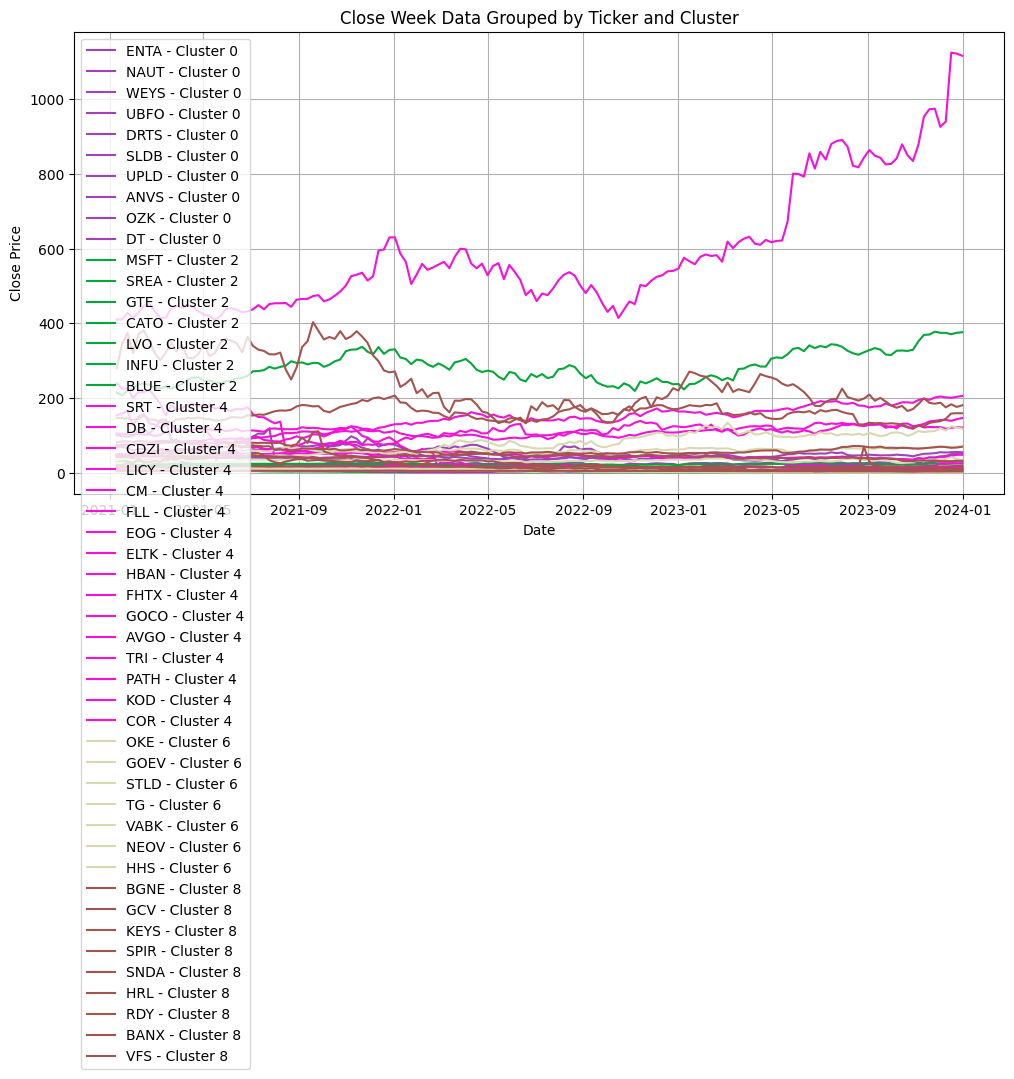

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

close_week_data = pd.read_csv("net_changes.csv", index_col=0, parse_dates=True)

# Normalize the data using Min-Max normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(close_week_data.values)

# Remove outliers using standard deviation
mean = np.mean(normalized_data, axis=0)
std = np.std(normalized_data, axis=0)
threshold = 3

filtered_data = normalized_data[~((normalized_data - mean) > threshold * std).any(axis=1)]

# Remove data with zero variance
variances = np.var(filtered_data, axis=0)
nonzero_variance_indices = np.where(variances != 0)[0]
filtered_data = filtered_data[:, nonzero_variance_indices]

# Handle NaN values
filtered_data = np.nan_to_num(filtered_data)

k = 10 # Number of clusters 
model = KMeans(n_clusters=k, random_state=42, max_iter=1000, tol=1e-4)
cluster_labels = model.fit_predict(filtered_data)

# Save the trained model using joblib
joblib.dump(model, 'kmeans_model.joblib')

ticker_clusters = {i: [] for i in range(k)}

for i, ticker in enumerate(close_week_data.columns):
    ticker_clusters[cluster_labels[i]].append(ticker)

print("Tickers in each Cluster:")
for cluster, tickers in ticker_clusters.items():
    print(f"Cluster {cluster}: {', '.join(tickers)}")

# Generate random colors for each cluster (NOT my code. Created using chatgpt)
random.seed(42)
cluster_colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for i in range(k)]

# Plotting the tickers in each cluster
plt.figure(figsize=(12, 6))
for cluster, tickers in ticker_clusters.items():
    for ticker in tickers:
        plt.plot(close_week_data.index, close_week_data[ticker], label=f"{ticker} - Cluster {cluster}", color=cluster_colors[cluster])

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Week Data Grouped by Ticker and Cluster")
plt.legend()
plt.grid(True)
plt.show()
